<a href="https://colab.research.google.com/github/jmerceron/AI-Activity/blob/main/Julien_VAE_MLP_Handwritten_Digits_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import keras

import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras

from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
#normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

#reshape
img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1
x_train = x_train.reshape(x_train.shape[0], img_width, img_height, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height, num_channels)
input_shape = (img_width, img_height, num_channels)

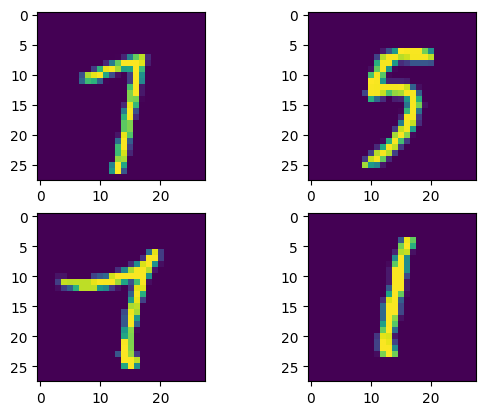

In [4]:
#display a few images !
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])
plt.show()

In [5]:
latent_dim = 2
n_hidden = 256

input_img = Input(shape=input_shape, name='encoder_input')
input_img_flattened = Flatten()(input_img)
x = Dense(n_hidden, activation='relu')(input_img_flattened)
x = Dense(n_hidden//2, activation='relu')(x)

#shape of the convolution network to be given to decoder part of VAE
mlp_shape = K.int_shape(x)

#define outputs of the encoder, our 2 variables
z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)

In [6]:
# reparametrization trick
def sample_z(args):
 z_mu, z_sigma = args
 eps = K.random_normal(shape=(K.shape(z_mu)[0],K.int_shape(z_mu)[1]))
 return z_mu + K.exp(z_sigma/2) * eps

z = Lambda(sample_z, output_shape=(latent_dim,), name='z')([z_mu, z_sigma])

#define the encoder part
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
#display encoder model
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['encoder_input[0][0]']       
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                            

In [7]:
decoder_input = Input(shape=(latent_dim,), name='decoder_input')

z_decoder = Dense(n_hidden//2, activation='relu')(decoder_input)
z_decoder = Dense(n_hidden, activation='relu')(z_decoder)
z_decoder = Dense(input_img_flattened.shape[1], activation='sigmoid')(z_decoder)
y = z_decoder

#define the decoder part
decoder = Model(decoder_input, y, name='decoder')
#display decoder model
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
Total params: 234896 (917.56 KB)
Trainable params: 234896 (917.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
z_decoded = decoder(z)

# loss
#kl_loss = 0.5 * K.sum(K.square(z_mu) + K.exp(z_sigma) - z_sigma - 1, axis = -1)
#x = K.flatten(x)
#z_decoded = K.flatten(z_decoded)
#reconstruction_loss = keras.metrics.binary_crossentropy(x, z_decoded)
#vae_loss = K.mean(reconstruction_loss + kl_loss)

class CustomLayer(keras.layers.Layer):

 def vae_loss(self, x, z_decoded):
   x = K.flatten(x)
   z_decoded = K.flatten(z_decoded)
   # reconstruction loss
   recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
   # KL divergence
   kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
   return K.mean(recon_loss + kl_loss)

 def call(self, inputs):
  x = inputs[0]
  z_decoded = inputs[1]
  loss = self.vae_loss(x, z_decoded)
  self.add_loss(loss, inputs=inputs)
  return x


y = CustomLayer()([input_img, z_decoded])

In [9]:
# model
vae = Model(input_img, y, name='vae')
#vae.add_loss(vae_loss)
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['encoder_input[0][0]']       
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                                

In [10]:
vae.fit(x_train, None, epochs = 15, batch_size = 32, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
47936/48000 [============================>.] - ETA: 0s - loss: 0.2230

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 13s 267us/sample - loss: 0.2230 - val_loss: 0.2043
Epoch 2/15
48000/48000 [==============================] - 11s 239us/sample - loss: 0.1996 - val_loss: 0.1949
Epoch 3/15
48000/48000 [==============================] - 12s 243us/sample - loss: 0.1930 - val_loss: 0.1906
Epoch 4/15
48000/48000 [==============================] - 11s 222us/sample - loss: 0.1894 - val_loss: 0.1875
Epoch 5/15
48000/48000 [==============================] - 12s 243us/sample - loss: 0.1868 - val_loss: 0.1853
Epoch 6/15
48000/48000 [==============================] - 13s 274us/sample - loss: 0.1846 - val_loss: 0.1840
Epoch 7/15
48000/48000 [==============================] - 12s 248us/sample - loss: 0.1829 - val_loss: 0.1826
Epoch 8/15
48000/48000 [==============================] - 12s 246us/sample - loss: 0.1814 - val_loss: 0.1806
Epoch 9/15
48000/48000 [==============================] - 12s 256us/sample - loss: 0.1802 - val_loss: 0.1801
Epoch 10/15
48000/48000 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


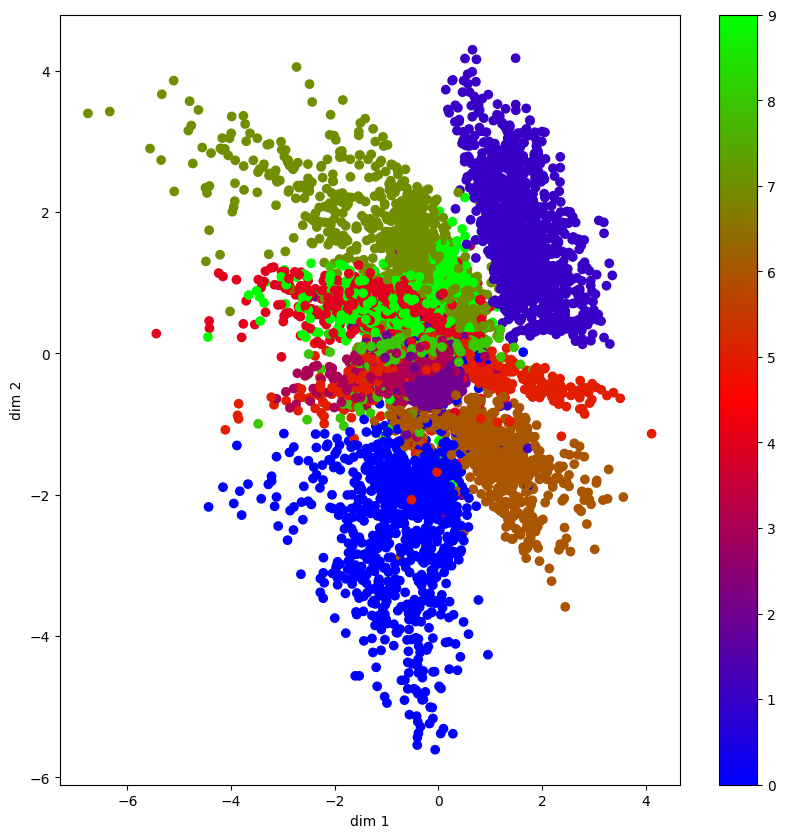

In [11]:
mu, _, _ = encoder.predict(x_test)

#plot dim1 and dim2 for mu
plt.figure(figsize=(10,10))
plt.scatter(mu[:,0], mu[:,1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

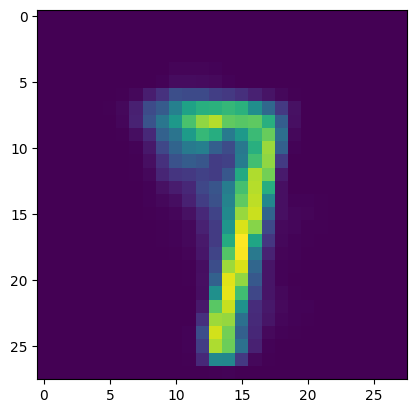

In [12]:
# looking at the schema above, [0,2] should land in the region of 9
sample_vector = np.array([[0,2]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

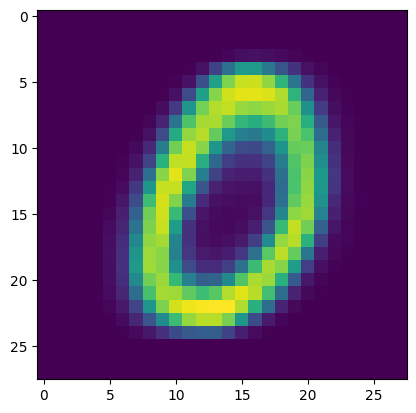

In [13]:
# looking at the schema above, [-1,-2] should land in the region of 0
sample_vector = np.array([[0,-2]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

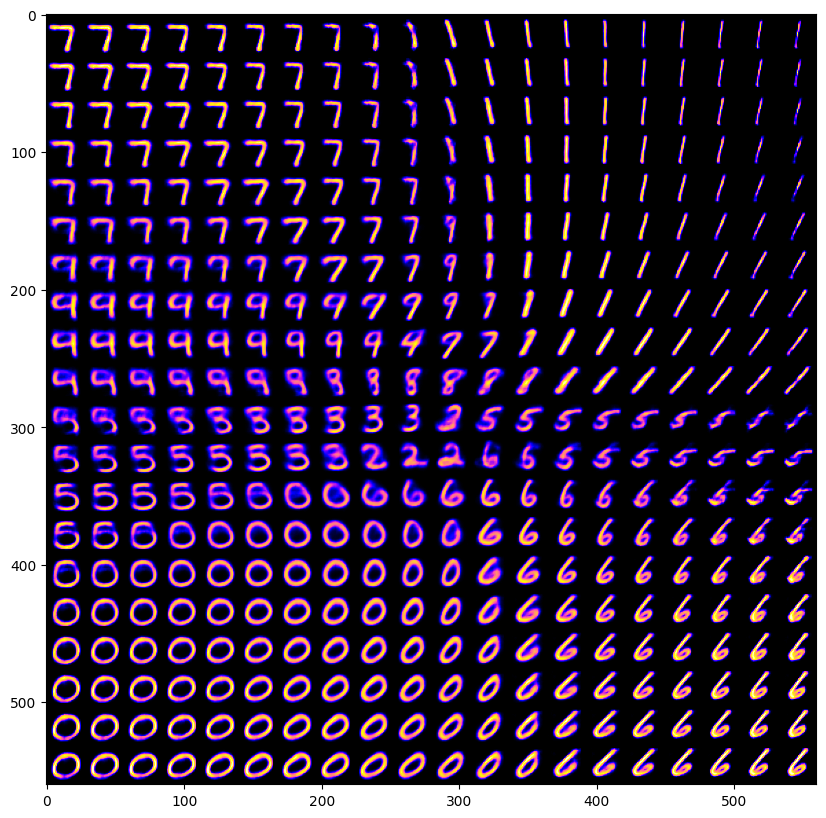

In [14]:
n=20
figure = np.zeros((img_width * n, img_height * n, num_channels))

grid_x = np.linspace(-4,4,n)
grid_y = np.linspace(-4,4,n)[::-1]

for i, yi in enumerate(grid_y):
 for j, xi in enumerate(grid_x):
  z_sample = np.array([[xi,yi]])
  x_decoded = decoder.predict(z_sample)
  digit = x_decoded[0].reshape(img_width, img_height, num_channels)
  figure[i * img_width: (i+1) * img_width, j * img_height: (j+1) * img_height] = digit

plt.figure(figsize=(10,10))
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()